# Deterministic Linear Transport equation
---
Consider the equation
$$
\left\{
\begin{aligned}
&\frac{\partial r}{\partial t} + v\frac{\partial j}{\partial x} = \frac{\sigma(x, z)}{\epsilon^2}(\hat{r} - r), \\
&\frac{\partial j}{\partial t} + \frac{v}{\epsilon^2}\frac{\partial r}{\partial x} = - \frac{\sigma(x, z)}{\epsilon^2}j, 
\end{aligned}
\right.
$$
where $\epsilon$ is a small number, $v \in [0, 1]$, and $\hat{r} = \int_{0}^{1} rdv$. 

It seems to me that $v$ follows a uniform distribution (as Gauss-Legendre quadrature is used to compute the integral).

We let $\sigma(x, z) \equiv 1$.

The initial data are
$$
\begin{aligned}
&r = 1, \ x < 0.5 \\
&r = 0, x \ge 0.5 \\
&j = 0.
\end{aligned}
$$
$$

BC: for all $v, x, t$,
$$
\sigma j = -v r_{x}, 
$$
and for all $v$, 
$$
r - \frac{\epsilon}{\sigma}vr_x{\Large \bracevert}_{x = 0} = 1, \quad r + \frac{\epsilon}{\sigma}vr_x{\Large \bracevert}_{x = 1} = 0.
$$

The spatiotemporal domain is 
$$
(x, t, v) \in [0, 1]\times [0, 0.01] \times [0, 1].
$$

In [1]:
NAME = "2_1e-8_new_ic"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers
from jax.ops import index, index_add, index_update


import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *
from Seismic_wave_inversion_PINN.jax_model import *

from collections import namedtuple
# from jax.config import config; config.update("jax_enable_x64", True)
# dtype = jnp.float64
dtype = jnp.float32

In [3]:
key = random.PRNGKey(1)
key, subkey = random.split(key, 2)

layers = [3] + [32]*4 + [2] # (x, t, v) -> (r, j)
c0 = 1.0
w0 = jnp.array([[1.0, 1.0, 1.0]]).T
w1 = jnp.array([[1.0, 1.0]]) # (w_r, w_j)
direct_params = init_siren_params(subkey, layers, c0, w0, w1, dtype)

domain = jnp.array([[0., 0., 0.0], [1., 0.01, 1.0]])

sigma = 1.0
epsilon = 1e-8

@jax.jit
def model(params, xtv): # for predictions
	# linear scaling
	xtv = (2*xtv - (domain[0, :]+domain[1, :]))/(domain[1, :] - domain[0, :])
	for w, b in params[:-1]:
		xtv = jnp.sin(jnp.dot(xtv, w) + b)
	return jnp.dot(xtv, params[-1][0]) + params[-1][1]

# @jax.jit
# def model_(params, xt): # for derivatives
# 	for w, b in params[:-1]:
# 		xt = jnp.sin(jnp.dot(xt, w) + b)
# 	return jnp.dot(xt, params[-1][0]) + params[-1][1]

jacobian = jacrev_fn(model)
hessian = hessian_fn(model)

In [4]:
metaloss = mae

static_jit = lambda i: jax.partial(jax.jit, static_argnums = i)

@jax.jit
def quadrature(params, x, t, v, w):
	xt_ = jnp.repeat(jnp.hstack([x, t]), w.shape[0], axis = 0)
	v_ = jnp.tile(v, (x.shape[0], 1))
	rj = model(params, jnp.hstack([xt_, v_]))
	r = rj[:, 0:1].reshape((x.shape[0], w.shape[0]))
	return jnp.dot(r, w)

# jacobian[i] = [[dr/dx, dr/dt, dr/dv],
#                [dj/dx, dj/dt, dj/dv]]
# i: the i^th input

# hessian[i] = [
#				[[du/dxx, du/dxy],
#                [du/dxy, du/dyy]],
#               [[dv/dxx, dv/dxy],
#                [dv/dxy, dv/dyy]]
#              ]
@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet, bc, quad = batch["collocation"], batch["dirichlet"], batch["bc"], batch["quad"]
	direct_params = params
	
	if collocation[0] is not None:
		rj_c = model(direct_params, jnp.hstack([collocation.x, collocation.t, collocation.v]))
		r_c, j_c = rj_c[:, 0:1], rj_c[:, 1:2]
		drj_dxtv_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t, collocation.v]))
		dr_dt_c, dj_dt_c = drj_dxtv_c[:, 0:1, 1], drj_dxtv_c[:, 1:2, 1]
		dr_dx_c, dj_dx_c = drj_dxtv_c[:, 0:1, 0], drj_dxtv_c[:, 1:2, 0]
		
		# quad.w: [q, 1]
		# quad.v: [q, 1]
		r_hat_c = quadrature(direct_params, collocation.x, collocation.t, quad.v, quad.w)
		
		loss_c1 = metaloss(epsilon**2*(dr_dt_c + collocation.v*dj_dx_c), sigma*(r_hat_c - r_c))
		loss_c2 = metaloss(epsilon**2*dj_dt_c + collocation.v*dr_dx_c, -sigma*j_c)
	else:
		loss_c1 = loss_c2 = 0
        
	if dirichlet[0] is not None:
		rj_d = model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t, dirichlet.v]))
		r_d, j_d = rj_d[:, 0:1], rj_d[:, 1:2]
		loss_d1 = metaloss(r_d, dirichlet.r)
		loss_d2 = metaloss(j_d, dirichlet.j)
		loss_d = loss_d1 + loss_d2
	else:
		loss_d = 0.0
		
	if bc[0] is not None:
		rj_bl = model(direct_params, jnp.hstack([bc.l, bc.t, bc.v]))
		rj_br = model(direct_params, jnp.hstack([bc.r, bc.t, bc.v]))
		r_bl, j_bl = rj_bl[:, 0:1], rj_bl[:, 1:2]
		r_br, j_br = rj_br[:, 0:1], rj_br[:, 1:2]
		drj_dxtv_bl = jacobian(direct_params, jnp.hstack([bc.l, bc.t, bc.v]))
		drj_dxtv_br = jacobian(direct_params, jnp.hstack([bc.r, bc.t, bc.v]))
		dr_dx_bl, dr_dx_br = drj_dxtv_bl[:, 0:1, 0], drj_dxtv_br[:, 0:1, 0]
		
		loss_b1 = metaloss(sigma*j_bl, -bc.v*dr_dx_bl) + metaloss(sigma*j_br, -bc.v*dr_dx_br)
		loss_b2 = metaloss(r_bl - epsilon/sigma*bc.v*dr_dx_bl, 1.0) + metaloss(r_br + epsilon/sigma*bc.v*dr_dx_br, 0.0)

	return loss_c1, loss_c2, loss_d, loss_b1, loss_b2

@jax.jit
def loss_fn(params, batch):
	w = batch["weights"]
	loss_c1, loss_c2, loss_d, loss_b1, loss_b2 = loss_fn_(params, batch)
	return w["c1"]*loss_c1 + w["c2"]*loss_c2 + w["d"]*loss_d + w["b1"]*loss_b1 + w["b2"]*loss_b2 + \
			l1_regularization(params, w["l1"]) + l2_regularization(params, w["l2"])

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	w = batch["weights"]
	loss_c1, loss_c2, loss_d, loss_b1, loss_b2 = loss_fn_(params, batch)
	l1 = l1_regularization(params, 1.0)
	l2 = l2_regularization(params, 1.0)
	return w["c1"]*loss_c1 + w["c2"]*loss_c2 + w["d"]*loss_d + w["b1"]*loss_b1 + w["b2"]*loss_b2, \
			loss_c1, loss_c2, loss_d, loss_b1, loss_b2, l1, l2

In [5]:
# r0_fn = lambda x, t, v: jnp.zeros_like(x)
# r0_fn = lambda x, t, v: jnp.select([jnp.isclose(x, domain[0, 0]), x > 0], [1.0, 0.0])
r0_fn = lambda x, t, v: jnp.select([x < 0.5, x >= 0.5], [1.0, 0.0])
j0_fn = lambda x, t, v: jnp.zeros_like(x)

# r0_fn_ = lambda xtv: jnp.zeros_like(xtv[0])
# j0_fn_ = lambda xtv: jnp.zeros_like(xtv[0])

# dr0_dt_fn = lambda xtv: jax.vmap(jax.jacfwd(r0_fn_), in_axes = 0)(xtv)[:, 1:2]
# dj0_dt_fn = lambda xtv: jax.vmap(jax.jacfwd(j0_fn_), in_axes = 0)(xtv)[:, 1:2]

# dr0_dx_fn = lambda xtv: jax.vmap(jax.jacfwd(r0_fn_), in_axes = 0)(xtv)[:, 0:1]
# dj0_dx_fn = lambda xtv: jax.vmap(jax.jacfwd(j0_fn_), in_axes = 0)(xtv)[:, 0:1]

key, *subkeys = random.split(key, 3)

n_quad = 16
v_quad, w_quad = np.polynomial.legendre.leggauss(n_quad)
v_quad = jnp.array(0.5*(v_quad+1), dtype = jnp.float32).reshape((-1, 1))
w_quad = jnp.array(0.5*w_quad, dtype = jnp.float32).reshape((-1, 1))

n_i = 200
x_i = jnp.linspace(*domain[:, 0], n_i)
# v_i = jnp.linspace(*domain[:, 2], n_i)
v_i = v_quad
xv_i = tensor_grid([x_i, v_i])
x_i, v_i = xv_i[:, 0:1], xv_i[:, 1:2]
t_i = jnp.zeros_like(x_i)
r_i = r0_fn(x_i, t_i, v_i)
j_i = j0_fn(x_i, t_i, v_i)

n_b = 100
t_b = jnp.linspace(*domain[:, 1], n_b)
# v_b = jnp.linspace(*domain[:, 2], n_b)
v_b = v_quad
tv_b = tensor_grid([t_b, v_b])
t_b, v_b = tv_b[:, 0:1], tv_b[:, 1:2]
x_bl = jnp.ones_like(t_b)*domain[0, 0]
x_br = jnp.ones_like(t_b)*domain[1, 0]

n_cx = 201
n_ct = 100
x_c = jnp.linspace(*domain[:, 0], n_cx).reshape((-1, 1))
t_c = jnp.linspace(*domain[:, 1], n_ct).reshape((-1, 1))
# v_c = jnp.linspace(*domain[:, 2], n_cv).reshape((-1, 1))
v_c = v_quad
xtv_c = tensor_grid([x_c, t_c, v_c])

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "t", "v", "r", "j"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t", "v"])
dataset_Quad = namedtuple("dataset_Quad", ["w", "v"])
dataset_BC = namedtuple("dataset_BC", ["l", "r", "t", "v"])

dirichlet = dataset_Dirichlet(x_i, t_i, v_i, r_i, j_i)
collocation = dataset_Collocation(xtv_c[:, 0:1], xtv_c[:, 1:2], xtv_c[:, 2:3])
quad = dataset_Quad(w_quad, v_quad)
bc = dataset_BC(x_bl, x_br, t_b, v_b)

In [6]:
# class Time_Marching_Generator:
# 	def __init__(self, key, spatial_points, temporal_domain, batch_size, iterations, update_every, count1 = 0):
# 		self.key = key
# 		self.spatial_points = spatial_points
# 		self.domain = temporal_domain
# 		self.batch_size = batch_size
# 		self.iterations = iterations
# 		self._count1 = count1
# 		self._count2 = update_every
# 		if count1 < iterations:
# 			self._update(self.domain[0])
# 		else:
# 			self._update(self.domain[1])
# 		self.update_every = update_every
		
# 	def _update(self, tmax):
# 		self.key, subkey = random.split(self.key)
# 		self._t = random.uniform(key, (self.batch_size, 1), jnp.float32, self.domain[0], tmax)
		
# 	def __iter__(self):
# 		return self
	
# 	def __next__(self):
# 		if self._count2 == self.update_every:
# 			self._count1 = max(self.iterations, self._count1 + 1)
# 			tmax = self.domain[0] + (self.domain[1]-self.domain[0])*self._count1/self.iterations
# 			self._update(tmax)
# 			self._count2 = 0
# 		else:
# 			self._count2 += 1
# 		return self.spatial_points, self._t

In [7]:
lr = 1e-3
params = direct_params
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
hist = {"iter": [], "loss": []}

batch_size = {"dirichlet": 3200, "collocation": 20100, "bc": 1600}
key, *subkeys = random.split(key, 5)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])
BC = Batch_Generator(subkeys[2], bc, batch_size["bc"])

start_iteration = 0
iterations = 10000
print_every = 200
save_every = 10000
weights = {"c1": 1.0, "c2": 1, "d": 1, "b1": 1, "b2": 1, "l1": 1e-8, "l2": 1e-8}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	b = next(BC)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"bc": dataset_BC(*b),
		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0], b[0], b[1]]), jnp.vstack([d[1], c[1], b[2], b[2]]), jnp.vstack([d[2], c[2], b[3], b[3]])),
		"quad": quad,
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c1", "c2", "d", "b1", "b2", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"bc": dataset_BC(*BC.dataset),
			"collocation": batch["collocation"],
			"quad": quad,
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/28, 23:23:58, Iteration: 0, Train Loss: 1.8640e+00, c1: 2.0621e-02, c2: 9.5665e-02, d: 5.7365e-01, b1: 1.8762e-01, b2: 9.8649e-01, l1_reg: 3.0192e+02, l2_reg: 4.2645e+01
2020/08/28, 23:24:02, Iteration: 200, Train Loss: 7.2336e-01, c1: 7.1140e-03, c2: 1.0722e-01, d: 5.7637e-01, b1: 1.7338e-02, b2: 1.5317e-02, l1_reg: 3.1164e+02, l2_reg: 4.5309e+01
2020/08/28, 23:24:06, Iteration: 400, Train Loss: 6.1698e-01, c1: 2.4533e-03, c2: 3.3518e-01, d: 2.2359e-01, b1: 4.8117e-02, b2: 7.6412e-03, l1_reg: 3.1814e+02, l2_reg: 4.7840e+01
2020/08/28, 23:24:10, Iteration: 600, Train Loss: 5.7214e-01, c1: 3.4237e-03, c2: 2.5130e-01, d: 2.3798e-01, b1: 6.4092e-02, b2: 1.5336e-02, l1_reg: 3.2249e+02, l2_reg: 4.9561e+01
2020/08/28, 23:24:14, Iteration: 800, Train Loss: 4.8026e-01, c1: 2.7883e-03, c2: 2.2399e-01, d: 1.9788e-01, b1: 4.8652e-02, b2: 6.9458e-03, l1_reg: 3.2859e+02, l2_reg: 5.2662e+01
2020/08/28, 23:24:18, Iteration: 1000, Train Loss: 4.5556e-01, c1: 4.5119e-03, c2: 1.7961e-01, d: 2.03

2020/08/28, 23:27:11, Iteration: 9200, Train Loss: 2.0594e-01, c1: 4.1929e-03, c2: 1.4266e-01, d: 4.7115e-02, b1: 8.4433e-03, b2: 3.5277e-03, l1_reg: 3.8599e+02, l2_reg: 7.9826e+01
2020/08/28, 23:27:15, Iteration: 9400, Train Loss: 2.3155e-01, c1: 4.1484e-03, c2: 1.4602e-01, d: 5.0667e-02, b1: 2.6237e-02, b2: 4.4862e-03, l1_reg: 3.8738e+02, l2_reg: 8.0449e+01
2020/08/28, 23:27:19, Iteration: 9600, Train Loss: 2.1179e-01, c1: 4.2979e-03, c2: 1.4703e-01, d: 4.7013e-02, b1: 8.0835e-03, b2: 5.3660e-03, l1_reg: 3.8876e+02, l2_reg: 8.1109e+01
2020/08/28, 23:27:23, Iteration: 9800, Train Loss: 2.1355e-01, c1: 4.2196e-03, c2: 1.4584e-01, d: 4.7323e-02, b1: 1.1743e-02, b2: 4.4227e-03, l1_reg: 3.9010e+02, l2_reg: 8.1723e+01
2020/08/28, 23:27:28, Iteration: 10000, Train Loss: 2.0982e-01, c1: 4.3100e-03, c2: 1.4025e-01, d: 4.8072e-02, b1: 7.8578e-03, b2: 9.3280e-03, l1_reg: 3.9140e+02, l2_reg: 8.2322e+01


In [10]:
start_iteration = 10000
iterations = 1000000
print_every = 1000
save_every = 10000
weights = {"c1": 1, "c2": 1, "d": 1, "b1": 1, "b2": 1, "l1": 1e-8, "l2": 1e-8}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	b = next(BC)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"bc": dataset_BC(*b),
		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0], b[0], b[1]]), jnp.vstack([d[1], c[1], b[2], b[2]]), jnp.vstack([d[2], c[2], b[3], b[3]])),
		"quad": quad,
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c1", "c2", "d", "b1", "b2", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"bc": dataset_BC(*BC.dataset),
			"collocation": batch["collocation"],
			"quad": quad,
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/28, 23:30:43, Iteration: 10000, Train Loss: 2.0228e-01, c1: 4.3001e-03, c2: 1.4155e-01, d: 4.4299e-02, b1: 8.9832e-03, b2: 3.1554e-03, l1_reg: 3.9140e+02, l2_reg: 8.2326e+01
2020/08/28, 23:31:03, Iteration: 11000, Train Loss: 2.0410e-01, c1: 4.3888e-03, c2: 1.3686e-01, d: 4.4248e-02, b1: 1.4534e-02, b2: 4.0704e-03, l1_reg: 3.9766e+02, l2_reg: 8.5326e+01
2020/08/28, 23:31:23, Iteration: 12000, Train Loss: 1.8759e-01, c1: 4.4055e-03, c2: 1.3077e-01, d: 3.9705e-02, b1: 9.1511e-03, b2: 3.5572e-03, l1_reg: 4.0379e+02, l2_reg: 8.8372e+01
2020/08/28, 23:31:45, Iteration: 13000, Train Loss: 1.8157e-01, c1: 4.2235e-03, c2: 1.2257e-01, d: 3.8545e-02, b1: 1.2401e-02, b2: 3.8304e-03, l1_reg: 4.1095e+02, l2_reg: 9.1815e+01
2020/08/28, 23:32:06, Iteration: 14000, Train Loss: 1.7442e-01, c1: 4.0691e-03, c2: 1.1273e-01, d: 4.0036e-02, b1: 9.8738e-03, b2: 7.7124e-03, l1_reg: 4.1836e+02, l2_reg: 9.5518e+01
2020/08/28, 23:32:27, Iteration: 15000, Train Loss: 1.6304e-01, c1: 3.7397e-03, c2: 1.0482

2020/08/28, 23:46:54, Iteration: 56000, Train Loss: 1.0116e-01, c1: 1.1857e-03, c2: 7.7014e-02, d: 1.6818e-02, b1: 4.0926e-03, b2: 2.0539e-03, l1_reg: 5.1249e+02, l2_reg: 1.5792e+02
2020/08/28, 23:47:16, Iteration: 57000, Train Loss: 1.0718e-01, c1: 1.1221e-03, c2: 7.5870e-02, d: 1.9630e-02, b1: 8.0765e-03, b2: 2.4825e-03, l1_reg: 5.1346e+02, l2_reg: 1.5887e+02
2020/08/28, 23:47:37, Iteration: 58000, Train Loss: 9.9855e-02, c1: 1.0407e-03, c2: 7.6972e-02, d: 1.4642e-02, b1: 4.5951e-03, b2: 2.6051e-03, l1_reg: 5.1466e+02, l2_reg: 1.5993e+02
2020/08/28, 23:47:58, Iteration: 59000, Train Loss: 9.6088e-02, c1: 1.0171e-03, c2: 7.5443e-02, d: 1.4088e-02, b1: 3.5618e-03, b2: 1.9778e-03, l1_reg: 5.1572e+02, l2_reg: 1.6092e+02
2020/08/28, 23:48:18, Iteration: 60000, Train Loss: 9.7872e-02, c1: 1.0547e-03, c2: 7.4497e-02, d: 1.4869e-02, b1: 5.3491e-03, b2: 2.1023e-03, l1_reg: 5.1664e+02, l2_reg: 1.6184e+02
2020/08/28, 23:48:40, Iteration: 61000, Train Loss: 9.9711e-02, c1: 1.0617e-03, c2: 7.7077

2020/08/29, 00:03:04, Iteration: 102000, Train Loss: 9.1317e-02, c1: 7.8293e-04, c2: 7.5178e-02, d: 9.9220e-03, b1: 3.0537e-03, b2: 2.3805e-03, l1_reg: 5.5085e+02, l2_reg: 1.9742e+02
2020/08/29, 00:03:25, Iteration: 103000, Train Loss: 9.2691e-02, c1: 8.0121e-04, c2: 7.5951e-02, d: 9.2600e-03, b1: 3.9304e-03, b2: 2.7484e-03, l1_reg: 5.5155e+02, l2_reg: 1.9814e+02
2020/08/29, 00:03:46, Iteration: 104000, Train Loss: 9.1475e-02, c1: 8.5526e-04, c2: 7.2864e-02, d: 1.1075e-02, b1: 5.0569e-03, b2: 1.6240e-03, l1_reg: 5.5228e+02, l2_reg: 1.9882e+02
2020/08/29, 00:04:08, Iteration: 105000, Train Loss: 8.6304e-02, c1: 8.1592e-04, c2: 7.0284e-02, d: 9.7765e-03, b1: 3.9547e-03, b2: 1.4732e-03, l1_reg: 5.5289e+02, l2_reg: 1.9945e+02
2020/08/29, 00:04:29, Iteration: 106000, Train Loss: 8.5763e-02, c1: 7.7137e-04, c2: 7.2036e-02, d: 9.7110e-03, b1: 2.4960e-03, b2: 7.4847e-04, l1_reg: 5.5355e+02, l2_reg: 2.0012e+02
2020/08/29, 00:04:50, Iteration: 107000, Train Loss: 8.6284e-02, c1: 8.3083e-04, c2: 

2020/08/29, 00:18:51, Iteration: 147000, Train Loss: 8.6620e-02, c1: 5.6022e-04, c2: 7.3907e-02, d: 7.2700e-03, b1: 3.2031e-03, b2: 1.6797e-03, l1_reg: 5.7935e+02, l2_reg: 2.2955e+02
2020/08/29, 00:19:12, Iteration: 148000, Train Loss: 8.3305e-02, c1: 6.4206e-04, c2: 7.0300e-02, d: 7.1898e-03, b1: 3.2719e-03, b2: 1.9018e-03, l1_reg: 5.7980e+02, l2_reg: 2.3020e+02
2020/08/29, 00:19:33, Iteration: 149000, Train Loss: 8.6833e-02, c1: 5.4606e-04, c2: 7.3012e-02, d: 9.0708e-03, b1: 2.2120e-03, b2: 1.9912e-03, l1_reg: 5.8040e+02, l2_reg: 2.3092e+02
2020/08/29, 00:19:55, Iteration: 150000, Train Loss: 7.9542e-02, c1: 5.2876e-04, c2: 6.7581e-02, d: 7.6253e-03, b1: 2.5144e-03, b2: 1.2926e-03, l1_reg: 5.8088e+02, l2_reg: 2.3157e+02
2020/08/29, 00:20:15, Iteration: 151000, Train Loss: 8.6588e-02, c1: 5.4770e-04, c2: 7.5081e-02, d: 6.5346e-03, b1: 3.0332e-03, b2: 1.3921e-03, l1_reg: 5.8129e+02, l2_reg: 2.3226e+02
2020/08/29, 00:20:37, Iteration: 152000, Train Loss: 8.6949e-02, c1: 5.5150e-04, c2: 

2020/08/29, 00:34:38, Iteration: 192000, Train Loss: 8.1380e-02, c1: 4.8765e-04, c2: 7.0719e-02, d: 8.0508e-03, b1: 1.5282e-03, b2: 5.9398e-04, l1_reg: 6.0746e+02, l2_reg: 2.6291e+02
2020/08/29, 00:34:59, Iteration: 193000, Train Loss: 8.6298e-02, c1: 4.9691e-04, c2: 7.4998e-02, d: 7.0614e-03, b1: 1.9052e-03, b2: 1.8371e-03, l1_reg: 6.0818e+02, l2_reg: 2.6376e+02
2020/08/29, 00:35:21, Iteration: 194000, Train Loss: 8.0685e-02, c1: 4.7230e-04, c2: 6.8855e-02, d: 7.5658e-03, b1: 2.2648e-03, b2: 1.5272e-03, l1_reg: 6.0863e+02, l2_reg: 2.6452e+02
2020/08/29, 00:35:42, Iteration: 195000, Train Loss: 7.9181e-02, c1: 4.9414e-04, c2: 6.8989e-02, d: 5.9185e-03, b1: 2.4631e-03, b2: 1.3156e-03, l1_reg: 6.0925e+02, l2_reg: 2.6526e+02
2020/08/29, 00:36:03, Iteration: 196000, Train Loss: 8.7418e-02, c1: 4.6380e-04, c2: 7.4796e-02, d: 7.5348e-03, b1: 2.4142e-03, b2: 2.2091e-03, l1_reg: 6.0988e+02, l2_reg: 2.6612e+02
2020/08/29, 00:36:24, Iteration: 197000, Train Loss: 8.2290e-02, c1: 4.9760e-04, c2: 

2020/08/29, 00:50:25, Iteration: 237000, Train Loss: 7.9770e-02, c1: 4.4950e-04, c2: 7.0386e-02, d: 5.2776e-03, b1: 2.6170e-03, b2: 1.0401e-03, l1_reg: 6.3406e+02, l2_reg: 2.9483e+02
2020/08/29, 00:50:46, Iteration: 238000, Train Loss: 7.7867e-02, c1: 4.2629e-04, c2: 6.9868e-02, d: 4.4128e-03, b1: 1.9861e-03, b2: 1.1747e-03, l1_reg: 6.3468e+02, l2_reg: 2.9546e+02
2020/08/29, 00:51:07, Iteration: 239000, Train Loss: 7.6931e-02, c1: 4.3442e-04, c2: 6.5397e-02, d: 6.2636e-03, b1: 2.9784e-03, b2: 1.8573e-03, l1_reg: 6.3502e+02, l2_reg: 2.9591e+02
2020/08/29, 00:51:28, Iteration: 240000, Train Loss: 7.8912e-02, c1: 4.5051e-04, c2: 7.0303e-02, d: 5.0359e-03, b1: 1.8231e-03, b2: 1.2988e-03, l1_reg: 6.3566e+02, l2_reg: 2.9655e+02
2020/08/29, 00:51:49, Iteration: 241000, Train Loss: 7.7698e-02, c1: 4.3196e-04, c2: 6.8719e-02, d: 5.1374e-03, b1: 1.8869e-03, b2: 1.5229e-03, l1_reg: 6.3629e+02, l2_reg: 2.9715e+02
2020/08/29, 00:52:10, Iteration: 242000, Train Loss: 8.1364e-02, c1: 4.2978e-04, c2: 

2020/08/29, 01:06:11, Iteration: 282000, Train Loss: 7.6576e-02, c1: 3.7788e-04, c2: 6.9316e-02, d: 4.0719e-03, b1: 2.0046e-03, b2: 8.0564e-04, l1_reg: 6.5739e+02, l2_reg: 3.2014e+02
2020/08/29, 01:06:32, Iteration: 283000, Train Loss: 7.8648e-02, c1: 4.0033e-04, c2: 6.8095e-02, d: 5.7005e-03, b1: 2.7683e-03, b2: 1.6838e-03, l1_reg: 6.5829e+02, l2_reg: 3.2080e+02
2020/08/29, 01:06:53, Iteration: 284000, Train Loss: 7.4813e-02, c1: 4.0364e-04, c2: 6.6298e-02, d: 4.9682e-03, b1: 1.7440e-03, b2: 1.3996e-03, l1_reg: 6.5858e+02, l2_reg: 3.2131e+02
2020/08/29, 01:07:14, Iteration: 285000, Train Loss: 7.6313e-02, c1: 3.7907e-04, c2: 6.7296e-02, d: 5.3628e-03, b1: 2.6695e-03, b2: 6.0589e-04, l1_reg: 6.5900e+02, l2_reg: 3.2179e+02
2020/08/29, 01:07:36, Iteration: 286000, Train Loss: 8.0091e-02, c1: 3.8014e-04, c2: 7.2446e-02, d: 4.6370e-03, b1: 1.0091e-03, b2: 1.6185e-03, l1_reg: 6.5948e+02, l2_reg: 3.2231e+02
2020/08/29, 01:07:57, Iteration: 287000, Train Loss: 7.7406e-02, c1: 3.9341e-04, c2: 

2020/08/29, 01:21:57, Iteration: 327000, Train Loss: 7.3041e-02, c1: 3.8991e-04, c2: 6.6246e-02, d: 4.6543e-03, b1: 6.8899e-04, b2: 1.0617e-03, l1_reg: 6.8034e+02, l2_reg: 3.4535e+02
2020/08/29, 01:22:18, Iteration: 328000, Train Loss: 7.7589e-02, c1: 3.5591e-04, c2: 7.0242e-02, d: 4.2900e-03, b1: 1.6889e-03, b2: 1.0119e-03, l1_reg: 6.8087e+02, l2_reg: 3.4599e+02
2020/08/29, 01:22:39, Iteration: 329000, Train Loss: 7.4521e-02, c1: 3.6297e-04, c2: 6.8777e-02, d: 3.6034e-03, b1: 1.4206e-03, b2: 3.5695e-04, l1_reg: 6.8152e+02, l2_reg: 3.4667e+02
2020/08/29, 01:23:00, Iteration: 330000, Train Loss: 8.0251e-02, c1: 3.6352e-04, c2: 7.2639e-02, d: 4.4277e-03, b1: 1.3550e-03, b2: 1.4657e-03, l1_reg: 6.8188e+02, l2_reg: 3.4740e+02
2020/08/29, 01:23:21, Iteration: 331000, Train Loss: 7.9654e-02, c1: 3.4298e-04, c2: 7.3612e-02, d: 3.9173e-03, b1: 1.3662e-03, b2: 4.1529e-04, l1_reg: 6.8233e+02, l2_reg: 3.4799e+02
2020/08/29, 01:23:42, Iteration: 332000, Train Loss: 7.6664e-02, c1: 3.7482e-04, c2: 

2020/08/29, 01:37:43, Iteration: 372000, Train Loss: 7.1761e-02, c1: 3.4893e-04, c2: 6.5339e-02, d: 3.8330e-03, b1: 1.3856e-03, b2: 8.5494e-04, l1_reg: 7.0230e+02, l2_reg: 3.7363e+02
2020/08/29, 01:38:04, Iteration: 373000, Train Loss: 7.3501e-02, c1: 3.7110e-04, c2: 6.7215e-02, d: 3.8079e-03, b1: 1.2834e-03, b2: 8.2405e-04, l1_reg: 7.0272e+02, l2_reg: 3.7443e+02
2020/08/29, 01:38:25, Iteration: 374000, Train Loss: 7.1145e-02, c1: 3.7486e-04, c2: 6.5045e-02, d: 3.5953e-03, b1: 9.9190e-04, b2: 1.1381e-03, l1_reg: 7.0325e+02, l2_reg: 3.7516e+02
2020/08/29, 01:38:46, Iteration: 375000, Train Loss: 7.7282e-02, c1: 3.7666e-04, c2: 6.9696e-02, d: 3.5986e-03, b1: 2.0605e-03, b2: 1.5504e-03, l1_reg: 7.0373e+02, l2_reg: 3.7600e+02
2020/08/29, 01:39:07, Iteration: 376000, Train Loss: 7.1789e-02, c1: 3.4063e-04, c2: 6.5404e-02, d: 3.9008e-03, b1: 1.4486e-03, b2: 6.9427e-04, l1_reg: 7.0396e+02, l2_reg: 3.7668e+02
2020/08/29, 01:39:28, Iteration: 377000, Train Loss: 7.4083e-02, c1: 3.3829e-04, c2: 

2020/08/29, 01:53:28, Iteration: 417000, Train Loss: 2.3645e-02, c1: 3.4431e-04, c2: 1.7697e-02, d: 1.6221e-03, b1: 2.0337e-03, b2: 1.9485e-03, l1_reg: 7.4611e+02, l2_reg: 4.5679e+02
2020/08/29, 01:53:49, Iteration: 418000, Train Loss: 1.1897e-02, c1: 3.2145e-04, c2: 6.6563e-03, d: 1.7460e-03, b1: 1.4553e-03, b2: 1.7175e-03, l1_reg: 7.4666e+02, l2_reg: 4.5767e+02
2020/08/29, 01:54:10, Iteration: 419000, Train Loss: 2.4297e-02, c1: 3.2709e-04, c2: 1.9729e-02, d: 2.1400e-03, b1: 1.1089e-03, b2: 9.9140e-04, l1_reg: 7.4683e+02, l2_reg: 4.5826e+02
2020/08/29, 01:54:31, Iteration: 420000, Train Loss: 1.1712e-02, c1: 2.9715e-04, c2: 7.2433e-03, d: 1.6792e-03, b1: 1.9622e-03, b2: 5.2974e-04, l1_reg: 7.4708e+02, l2_reg: 4.5907e+02
2020/08/29, 01:54:52, Iteration: 421000, Train Loss: 2.8810e-02, c1: 2.8910e-04, c2: 2.3741e-02, d: 2.3938e-03, b1: 1.5831e-03, b2: 8.0282e-04, l1_reg: 7.4739e+02, l2_reg: 4.5965e+02
2020/08/29, 01:55:13, Iteration: 422000, Train Loss: 2.2835e-02, c1: 2.9690e-04, c2: 

2020/08/29, 02:09:14, Iteration: 462000, Train Loss: 1.3312e-02, c1: 2.4809e-04, c2: 7.4741e-03, d: 2.8053e-03, b1: 1.5038e-03, b2: 1.2805e-03, l1_reg: 7.5625e+02, l2_reg: 4.8245e+02
2020/08/29, 02:09:35, Iteration: 463000, Train Loss: 1.8050e-02, c1: 2.7902e-04, c2: 1.3700e-02, d: 1.6573e-03, b1: 1.5016e-03, b2: 9.1213e-04, l1_reg: 7.5710e+02, l2_reg: 4.8293e+02
2020/08/29, 02:09:56, Iteration: 464000, Train Loss: 1.3170e-02, c1: 2.6543e-04, c2: 5.6873e-03, d: 2.7784e-03, b1: 1.9501e-03, b2: 2.4886e-03, l1_reg: 7.5665e+02, l2_reg: 4.8337e+02
2020/08/29, 02:10:17, Iteration: 465000, Train Loss: 1.6050e-02, c1: 2.5612e-04, c2: 1.1265e-02, d: 2.1659e-03, b1: 1.6480e-03, b2: 7.1475e-04, l1_reg: 7.5698e+02, l2_reg: 4.8394e+02
2020/08/29, 02:10:38, Iteration: 466000, Train Loss: 1.6834e-02, c1: 2.5007e-04, c2: 1.1310e-02, d: 2.4262e-03, b1: 1.7039e-03, b2: 1.1447e-03, l1_reg: 7.5706e+02, l2_reg: 4.8430e+02
2020/08/29, 02:10:58, Iteration: 467000, Train Loss: 9.3608e-03, c1: 2.6032e-04, c2: 

2020/08/29, 02:24:58, Iteration: 507000, Train Loss: 1.3505e-02, c1: 2.7552e-04, c2: 7.1637e-03, d: 2.5434e-03, b1: 1.7800e-03, b2: 1.7425e-03, l1_reg: 7.7438e+02, l2_reg: 5.3039e+02
2020/08/29, 02:25:19, Iteration: 508000, Train Loss: 1.3487e-02, c1: 2.7567e-04, c2: 7.2186e-03, d: 2.4116e-03, b1: 1.5179e-03, b2: 2.0630e-03, l1_reg: 7.7481e+02, l2_reg: 5.3168e+02
2020/08/29, 02:25:40, Iteration: 509000, Train Loss: 1.1295e-02, c1: 2.9421e-04, c2: 6.4155e-03, d: 1.9766e-03, b1: 1.6970e-03, b2: 9.1167e-04, l1_reg: 7.7519e+02, l2_reg: 5.3290e+02
2020/08/29, 02:26:01, Iteration: 510000, Train Loss: 1.0302e-02, c1: 2.8833e-04, c2: 5.3934e-03, d: 1.7573e-03, b1: 1.2755e-03, b2: 1.5876e-03, l1_reg: 7.7552e+02, l2_reg: 5.3385e+02
2020/08/29, 02:26:22, Iteration: 511000, Train Loss: 1.0963e-02, c1: 2.6882e-04, c2: 5.3264e-03, d: 2.3367e-03, b1: 2.2969e-03, b2: 7.3422e-04, l1_reg: 7.7569e+02, l2_reg: 5.3452e+02
2020/08/29, 02:26:43, Iteration: 512000, Train Loss: 1.0066e-02, c1: 2.7887e-04, c2: 

2020/08/29, 02:40:42, Iteration: 552000, Train Loss: 7.9685e-03, c1: 2.3998e-04, c2: 3.7972e-03, d: 1.3748e-03, b1: 1.2075e-03, b2: 1.3490e-03, l1_reg: 7.7739e+02, l2_reg: 5.4715e+02
2020/08/29, 02:41:03, Iteration: 553000, Train Loss: 1.0715e-02, c1: 2.2589e-04, c2: 5.1041e-03, d: 2.5509e-03, b1: 2.0717e-03, b2: 7.6247e-04, l1_reg: 7.7759e+02, l2_reg: 5.4750e+02
2020/08/29, 02:41:24, Iteration: 554000, Train Loss: 1.0805e-02, c1: 2.2969e-04, c2: 4.9865e-03, d: 2.2892e-03, b1: 1.6772e-03, b2: 1.6224e-03, l1_reg: 7.7754e+02, l2_reg: 5.4752e+02
2020/08/29, 02:41:45, Iteration: 555000, Train Loss: 1.0036e-02, c1: 2.4831e-04, c2: 5.3745e-03, d: 1.4152e-03, b1: 1.3231e-03, b2: 1.6745e-03, l1_reg: 7.7766e+02, l2_reg: 5.4783e+02
2020/08/29, 02:42:06, Iteration: 556000, Train Loss: 1.0652e-02, c1: 2.4291e-04, c2: 4.5615e-03, d: 1.6215e-03, b1: 1.4169e-03, b2: 2.8091e-03, l1_reg: 7.7784e+02, l2_reg: 5.4817e+02
2020/08/29, 02:42:27, Iteration: 557000, Train Loss: 7.5465e-03, c1: 2.2916e-04, c2: 

2020/08/29, 02:56:26, Iteration: 597000, Train Loss: 8.2986e-03, c1: 2.1183e-04, c2: 3.6642e-03, d: 1.0491e-03, b1: 1.4373e-03, b2: 1.9362e-03, l1_reg: 7.8263e+02, l2_reg: 5.5594e+02
2020/08/29, 02:56:47, Iteration: 598000, Train Loss: 7.2553e-03, c1: 2.2194e-04, c2: 3.7599e-03, d: 7.7979e-04, b1: 1.2270e-03, b2: 1.2667e-03, l1_reg: 7.8231e+02, l2_reg: 5.5642e+02
2020/08/29, 02:57:08, Iteration: 599000, Train Loss: 6.9870e-03, c1: 2.1075e-04, c2: 3.8051e-03, d: 8.4862e-04, b1: 7.9410e-04, b2: 1.3284e-03, l1_reg: 7.8262e+02, l2_reg: 5.5668e+02
2020/08/29, 02:57:29, Iteration: 600000, Train Loss: 7.7397e-03, c1: 2.0889e-04, c2: 4.4205e-03, d: 1.2397e-03, b1: 1.2239e-03, b2: 6.4673e-04, l1_reg: 7.8271e+02, l2_reg: 5.5663e+02
2020/08/29, 02:57:50, Iteration: 601000, Train Loss: 6.5983e-03, c1: 2.0313e-04, c2: 3.3750e-03, d: 1.0947e-03, b1: 1.2841e-03, b2: 6.4128e-04, l1_reg: 7.8288e+02, l2_reg: 5.5691e+02
2020/08/29, 02:58:11, Iteration: 602000, Train Loss: 6.9713e-03, c1: 2.0695e-04, c2: 

2020/08/29, 03:12:10, Iteration: 642000, Train Loss: 6.5939e-03, c1: 1.9583e-04, c2: 3.8337e-03, d: 9.7628e-04, b1: 9.3874e-04, b2: 6.4942e-04, l1_reg: 7.8788e+02, l2_reg: 5.6485e+02
2020/08/29, 03:12:30, Iteration: 643000, Train Loss: 8.3029e-03, c1: 1.9705e-04, c2: 3.9988e-03, d: 1.0643e-03, b1: 1.4245e-03, b2: 1.6183e-03, l1_reg: 7.8817e+02, l2_reg: 5.6518e+02
2020/08/29, 03:12:51, Iteration: 644000, Train Loss: 8.5179e-03, c1: 2.0239e-04, c2: 4.2552e-03, d: 1.1688e-03, b1: 1.2311e-03, b2: 1.6605e-03, l1_reg: 7.8819e+02, l2_reg: 5.6530e+02
2020/08/29, 03:13:12, Iteration: 645000, Train Loss: 5.3509e-03, c1: 1.9228e-04, c2: 2.7424e-03, d: 8.4310e-04, b1: 1.0394e-03, b2: 5.3364e-04, l1_reg: 7.8833e+02, l2_reg: 5.6566e+02
2020/08/29, 03:13:33, Iteration: 646000, Train Loss: 9.1963e-03, c1: 2.1569e-04, c2: 4.4873e-03, d: 1.8199e-03, b1: 1.3781e-03, b2: 1.2953e-03, l1_reg: 7.8860e+02, l2_reg: 5.6582e+02
2020/08/29, 03:13:54, Iteration: 647000, Train Loss: 7.6797e-03, c1: 1.9451e-04, c2: 

2020/08/29, 03:27:51, Iteration: 687000, Train Loss: 9.6724e-03, c1: 1.8500e-04, c2: 4.0349e-03, d: 2.1461e-03, b1: 1.2881e-03, b2: 2.0182e-03, l1_reg: 7.9242e+02, l2_reg: 5.7111e+02
2020/08/29, 03:28:12, Iteration: 688000, Train Loss: 6.8440e-03, c1: 1.7868e-04, c2: 3.8932e-03, d: 1.4191e-03, b1: 8.9628e-04, b2: 4.5679e-04, l1_reg: 7.9218e+02, l2_reg: 5.7121e+02
2020/08/29, 03:28:33, Iteration: 689000, Train Loss: 7.6293e-03, c1: 1.7150e-04, c2: 3.7485e-03, d: 1.1105e-03, b1: 1.1685e-03, b2: 1.4303e-03, l1_reg: 7.9241e+02, l2_reg: 5.7136e+02
2020/08/29, 03:28:54, Iteration: 690000, Train Loss: 7.9189e-03, c1: 2.3543e-04, c2: 4.0802e-03, d: 1.0006e-03, b1: 1.3169e-03, b2: 1.2858e-03, l1_reg: 7.9245e+02, l2_reg: 5.7141e+02
2020/08/29, 03:29:14, Iteration: 691000, Train Loss: 9.5356e-03, c1: 1.8767e-04, c2: 4.1156e-03, d: 1.6000e-03, b1: 1.4984e-03, b2: 2.1339e-03, l1_reg: 7.9242e+02, l2_reg: 5.7136e+02
2020/08/29, 03:29:35, Iteration: 692000, Train Loss: 9.2946e-03, c1: 1.7446e-04, c2: 

2020/08/29, 03:43:33, Iteration: 732000, Train Loss: 5.8978e-03, c1: 1.6444e-04, c2: 3.0306e-03, d: 1.0003e-03, b1: 9.9444e-04, b2: 7.0791e-04, l1_reg: 7.9520e+02, l2_reg: 5.7657e+02
2020/08/29, 03:43:54, Iteration: 733000, Train Loss: 5.4872e-03, c1: 1.6361e-04, c2: 2.7294e-03, d: 8.1465e-04, b1: 1.2993e-03, b2: 4.8032e-04, l1_reg: 7.9534e+02, l2_reg: 5.7669e+02
2020/08/29, 03:44:15, Iteration: 734000, Train Loss: 1.1339e-02, c1: 1.6800e-04, c2: 6.6120e-03, d: 1.6207e-03, b1: 1.1272e-03, b2: 1.8107e-03, l1_reg: 7.9531e+02, l2_reg: 5.7693e+02
2020/08/29, 03:44:36, Iteration: 735000, Train Loss: 7.9477e-03, c1: 1.6604e-04, c2: 4.3251e-03, d: 1.0658e-03, b1: 1.0837e-03, b2: 1.3071e-03, l1_reg: 7.9585e+02, l2_reg: 5.7701e+02
2020/08/29, 03:44:57, Iteration: 736000, Train Loss: 7.0214e-03, c1: 1.6400e-04, c2: 4.3269e-03, d: 8.0595e-04, b1: 9.1929e-04, b2: 8.0528e-04, l1_reg: 7.9554e+02, l2_reg: 5.7696e+02
2020/08/29, 03:45:18, Iteration: 737000, Train Loss: 8.1499e-03, c1: 1.6730e-04, c2: 

2020/08/29, 03:59:14, Iteration: 777000, Train Loss: 6.1499e-03, c1: 1.6219e-04, c2: 2.5579e-03, d: 1.0655e-03, b1: 9.4443e-04, b2: 1.4198e-03, l1_reg: 7.9882e+02, l2_reg: 5.8276e+02
2020/08/29, 03:59:35, Iteration: 778000, Train Loss: 5.3721e-03, c1: 1.5720e-04, c2: 2.6388e-03, d: 1.0045e-03, b1: 7.0881e-04, b2: 8.6276e-04, l1_reg: 7.9888e+02, l2_reg: 5.8283e+02
2020/08/29, 03:59:56, Iteration: 779000, Train Loss: 8.3538e-03, c1: 2.0860e-04, c2: 4.1125e-03, d: 8.2296e-04, b1: 2.6869e-03, b2: 5.2290e-04, l1_reg: 7.9917e+02, l2_reg: 5.8300e+02
2020/08/29, 04:00:17, Iteration: 780000, Train Loss: 7.6576e-03, c1: 1.5726e-04, c2: 3.8876e-03, d: 7.6994e-04, b1: 1.1848e-03, b2: 1.6580e-03, l1_reg: 7.9917e+02, l2_reg: 5.8329e+02
2020/08/29, 04:00:38, Iteration: 781000, Train Loss: 6.5756e-03, c1: 1.4989e-04, c2: 3.5591e-03, d: 5.2231e-04, b1: 1.4017e-03, b2: 9.4262e-04, l1_reg: 7.9919e+02, l2_reg: 5.8343e+02
2020/08/29, 04:00:59, Iteration: 782000, Train Loss: 6.1996e-03, c1: 1.5440e-04, c2: 

2020/08/29, 04:14:56, Iteration: 822000, Train Loss: 9.8391e-03, c1: 1.6734e-04, c2: 4.2708e-03, d: 1.5288e-03, b1: 1.6891e-03, b2: 2.1830e-03, l1_reg: 8.0262e+02, l2_reg: 5.8802e+02
2020/08/29, 04:15:17, Iteration: 823000, Train Loss: 6.2031e-03, c1: 1.6162e-04, c2: 3.4191e-03, d: 8.0663e-04, b1: 1.0200e-03, b2: 7.9578e-04, l1_reg: 8.0276e+02, l2_reg: 5.8813e+02
2020/08/29, 04:15:37, Iteration: 824000, Train Loss: 7.5262e-03, c1: 1.6089e-04, c2: 4.0274e-03, d: 8.8088e-04, b1: 1.2321e-03, b2: 1.2250e-03, l1_reg: 8.0278e+02, l2_reg: 5.8832e+02
2020/08/29, 04:15:58, Iteration: 825000, Train Loss: 6.0476e-03, c1: 1.4979e-04, c2: 2.6052e-03, d: 1.1191e-03, b1: 1.3153e-03, b2: 8.5820e-04, l1_reg: 8.0290e+02, l2_reg: 5.8866e+02
2020/08/29, 04:16:19, Iteration: 826000, Train Loss: 8.5748e-03, c1: 1.4892e-04, c2: 3.6197e-03, d: 1.1679e-03, b1: 2.8711e-03, b2: 7.6711e-04, l1_reg: 8.0289e+02, l2_reg: 5.8846e+02
2020/08/29, 04:16:40, Iteration: 827000, Train Loss: 7.9791e-03, c1: 1.5161e-04, c2: 

2020/08/29, 04:30:36, Iteration: 867000, Train Loss: 7.0782e-03, c1: 1.7286e-04, c2: 3.4726e-03, d: 6.6522e-04, b1: 1.1385e-03, b2: 1.6290e-03, l1_reg: 8.0622e+02, l2_reg: 5.9327e+02
2020/08/29, 04:30:56, Iteration: 868000, Train Loss: 6.0053e-03, c1: 1.5206e-04, c2: 2.8601e-03, d: 1.3951e-03, b1: 9.2367e-04, b2: 6.7442e-04, l1_reg: 8.0634e+02, l2_reg: 5.9341e+02
2020/08/29, 04:31:18, Iteration: 869000, Train Loss: 9.1313e-03, c1: 1.8019e-04, c2: 6.7302e-03, d: 6.7227e-04, b1: 8.9807e-04, b2: 6.5060e-04, l1_reg: 8.0665e+02, l2_reg: 5.9425e+02
2020/08/29, 04:31:38, Iteration: 870000, Train Loss: 5.6556e-03, c1: 1.5851e-04, c2: 2.5140e-03, d: 1.1486e-03, b1: 7.3352e-04, b2: 1.1010e-03, l1_reg: 8.0661e+02, l2_reg: 5.9405e+02
2020/08/29, 04:31:59, Iteration: 871000, Train Loss: 7.0083e-03, c1: 1.5308e-04, c2: 3.7359e-03, d: 1.0853e-03, b1: 7.8293e-04, b2: 1.2512e-03, l1_reg: 8.0648e+02, l2_reg: 5.9396e+02
2020/08/29, 04:32:20, Iteration: 872000, Train Loss: 7.9203e-03, c1: 1.4755e-04, c2: 

2020/08/29, 04:46:16, Iteration: 912000, Train Loss: 5.5929e-03, c1: 1.4059e-04, c2: 2.6865e-03, d: 9.1556e-04, b1: 8.3138e-04, b2: 1.0188e-03, l1_reg: 8.0917e+02, l2_reg: 5.9829e+02
2020/08/29, 04:46:37, Iteration: 913000, Train Loss: 5.6167e-03, c1: 1.6601e-04, c2: 2.6949e-03, d: 8.6025e-04, b1: 1.1134e-03, b2: 7.8221e-04, l1_reg: 8.0910e+02, l2_reg: 5.9828e+02
2020/08/29, 04:46:58, Iteration: 914000, Train Loss: 6.7751e-03, c1: 1.4993e-04, c2: 3.4315e-03, d: 6.7988e-04, b1: 1.2644e-03, b2: 1.2494e-03, l1_reg: 8.0930e+02, l2_reg: 5.9843e+02
2020/08/29, 04:47:19, Iteration: 915000, Train Loss: 5.9515e-03, c1: 1.4214e-04, c2: 2.8361e-03, d: 1.0331e-03, b1: 4.8594e-04, b2: 1.4542e-03, l1_reg: 8.0916e+02, l2_reg: 5.9838e+02
2020/08/29, 04:47:40, Iteration: 916000, Train Loss: 7.0038e-03, c1: 1.3875e-04, c2: 3.4923e-03, d: 8.6763e-04, b1: 1.2762e-03, b2: 1.2289e-03, l1_reg: 8.0951e+02, l2_reg: 5.9851e+02
2020/08/29, 04:48:01, Iteration: 917000, Train Loss: 5.3467e-03, c1: 1.4204e-04, c2: 

2020/08/29, 05:01:58, Iteration: 957000, Train Loss: 6.1136e-03, c1: 1.4875e-04, c2: 3.0228e-03, d: 9.8990e-04, b1: 5.4364e-04, b2: 1.4085e-03, l1_reg: 8.0641e+02, l2_reg: 6.0190e+02
2020/08/29, 05:02:19, Iteration: 958000, Train Loss: 5.1026e-03, c1: 1.3819e-04, c2: 2.4817e-03, d: 9.8396e-04, b1: 4.9440e-04, b2: 1.0044e-03, l1_reg: 8.0656e+02, l2_reg: 6.0185e+02
2020/08/29, 05:02:40, Iteration: 959000, Train Loss: 7.1591e-03, c1: 1.6819e-04, c2: 3.3158e-03, d: 1.1460e-03, b1: 1.6914e-03, b2: 8.3773e-04, l1_reg: 8.0652e+02, l2_reg: 6.0202e+02
2020/08/29, 05:03:01, Iteration: 960000, Train Loss: 5.3578e-03, c1: 1.3523e-04, c2: 2.7650e-03, d: 5.7602e-04, b1: 8.8571e-04, b2: 9.9590e-04, l1_reg: 8.0651e+02, l2_reg: 6.0223e+02
2020/08/29, 05:03:22, Iteration: 961000, Train Loss: 7.7711e-03, c1: 1.3609e-04, c2: 3.7668e-03, d: 1.5865e-03, b1: 1.3446e-03, b2: 9.3710e-04, l1_reg: 8.0659e+02, l2_reg: 6.0219e+02
2020/08/29, 05:03:43, Iteration: 962000, Train Loss: 6.6069e-03, c1: 1.4307e-04, c2: 

2020/08/29, 05:17:39, Iteration: 1002000, Train Loss: 5.7099e-03, c1: 1.3259e-04, c2: 3.1248e-03, d: 9.5522e-04, b1: 6.5897e-04, b2: 8.3832e-04, l1_reg: 8.0760e+02, l2_reg: 6.0682e+02
2020/08/29, 05:18:00, Iteration: 1003000, Train Loss: 6.5504e-03, c1: 1.4792e-04, c2: 2.5965e-03, d: 1.1863e-03, b1: 1.5877e-03, b2: 1.0321e-03, l1_reg: 8.0755e+02, l2_reg: 6.0670e+02
2020/08/29, 05:18:21, Iteration: 1004000, Train Loss: 8.0032e-03, c1: 1.4498e-04, c2: 3.3263e-03, d: 1.0899e-03, b1: 1.8666e-03, b2: 1.5755e-03, l1_reg: 8.0768e+02, l2_reg: 6.0691e+02
2020/08/29, 05:18:42, Iteration: 1005000, Train Loss: 5.8029e-03, c1: 1.3623e-04, c2: 2.7889e-03, d: 6.8632e-04, b1: 1.2237e-03, b2: 9.6776e-04, l1_reg: 8.0754e+02, l2_reg: 6.0718e+02
2020/08/29, 05:19:03, Iteration: 1006000, Train Loss: 7.0859e-03, c1: 1.2731e-04, c2: 3.1147e-03, d: 1.1470e-03, b1: 1.1275e-03, b2: 1.5694e-03, l1_reg: 8.0772e+02, l2_reg: 6.0719e+02
2020/08/29, 05:19:24, Iteration: 1007000, Train Loss: 5.8911e-03, c1: 1.4889e-04

In [28]:
from scipy.io import loadmat
params_ = get_params(opt_state)

data_true = loadmat("4_snapshots_epsilon_1e-8_3.mat")
x_test = data_true["x"]
t_test = data_true["times"][0]
r_hat_trues = data_true["rhos"].T

# x_test = jnp.linspace(*domain[:, 0], 200)
# t_test = jnp.linspace(*domain[:, 1], 2000)
xt_tests = [tensor_grid([x_test, ti]) for ti in t_test]

r_hat_preds = [quadrature(params_, xt[:, 0:1], xt[:, 1:2], quad.v, quad.w) for xt in xt_tests]
# uv_preds = [model(params_, xt_test) for xt_test in xt_tests]
# u_preds, v_preds = [uv_pred[:, 0:1] for uv_pred in uv_preds], [uv_pred[:, 1:2] for uv_pred in uv_preds]
# duv_dxt_preds = [jacobian(params_, xt_test) for xt_test in xt_tests]
# du_dx_preds, dv_dx_preds = [duv_dxt_pred[:, 0:1, 0] for duv_dxt_pred in duv_dxt_preds], [duv_dxt_pred[:, 1:2, 0] for duv_dxt_pred in duv_dxt_preds]
# du_dt_preds, dv_dt_preds = [duv_dxt_pred[:, 0:1, 1] for duv_dxt_pred in duv_dxt_preds], [duv_dxt_pred[:, 1:2, 1] for duv_dxt_pred in duv_dxt_preds]

<IPython.core.display.Javascript object>


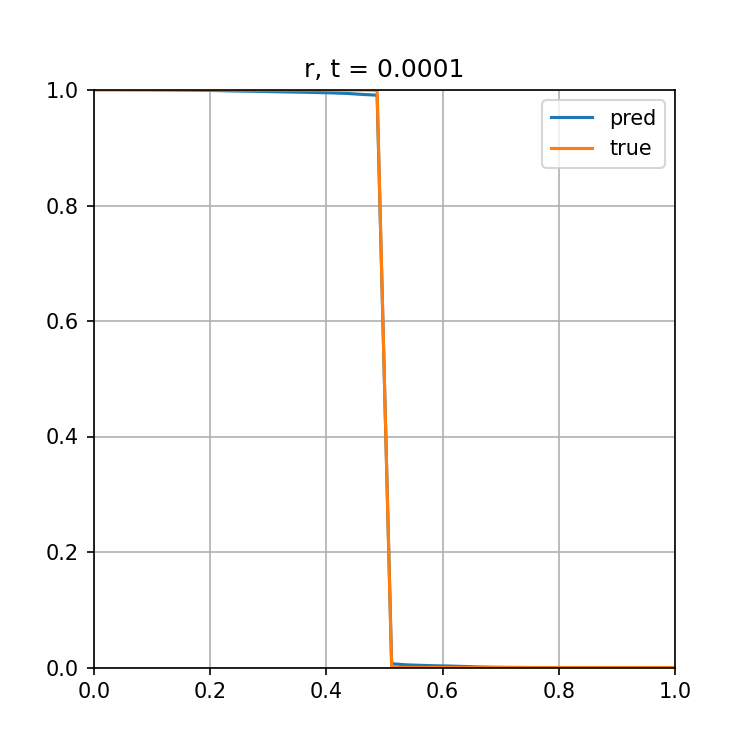

In [14]:
from matplotlib import animation
%matplotlib notebook

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
line1, = ax.plot([], [], lw = 1.5, label = "pred")
line2, = ax.plot([], [], lw = 1.5, label = "true")
lines = [line1, line2]
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.legend()
ax.grid()
    
def init():
	for line in lines:
		line.set_data([], [])
	return lines

def animate(i):
	r_hat_pred = r_hat_preds[i]
	r_hat_true = r_hat_trues[i]
	lines[0].set_data(x_test, r_hat_pred)
	lines[1].set_data(x_test, r_hat_true)
	ax.set_title("r, t = {:.4f}".format(t_test[i]))
	return lines

anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 100, blit = True)
plt.show()

<IPython.core.display.Javascript object>


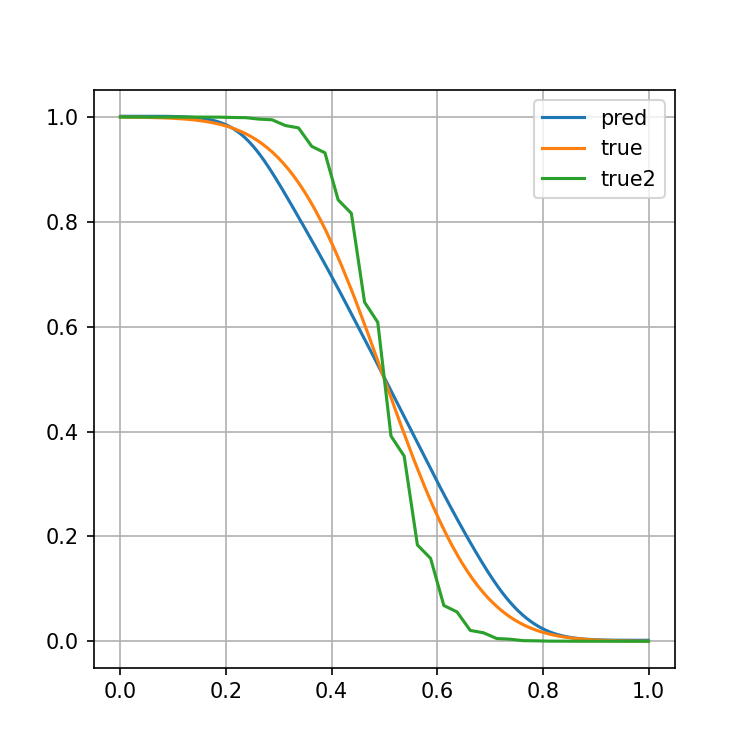

In [29]:
from scipy.io import loadmat
data_true = loadmat("4_snapshots_epsilon_1e-8_3.mat")
x_test = data_true["x"]
t_test = data_true["times"][0]
r_hat_trues = data_true["rhos"].T

data_true2 =  loadmat("4_snapshots_epsilon_1e-8.mat")
x_test2 = data_true2["x"]
r_hat_trues2 = data_true2["rhos"].T

f, ax = plt.subplots(1, 1, figsize = (5, 5))
ax.plot(x_test, r_hat_preds[-1], label = "pred")
ax.plot(x_test, r_hat_trues[-1, 1:-1], label = "true")
ax.plot(x_test2, r_hat_trues2[-1], label = "true2")
ax.legend()
ax.grid()
plt.show()

In [ ]:
# from matplotlib import animation
# %matplotlib notebook

# fig, ax = plt.subplots(2, 3, figsize = (15, 10))
# lines = []
# for i in range(2):
# 	for j in range(3):
# 		line, = ax[i][j].plot([], [], lw = 1.5, label = "pred")
# 		lines.append(line)
# 		ax[i][j].set_xlim([-1, 1])
# 		ax[i][j].set_ylim([-5, 5])
# 		ax[i][j].legend()
# 		ax[i][j].grid()
# ax[0][0].set_ylim([0.9, 2.1])
# ax[1][0].set_ylim([-0.1, 1.0])
    
# def init():
# 	for line in lines:
# 		line.set_data([], [])
# 	return lines

# def animate(i):
# 	u_pred, v_pred = u_preds[i], v_preds[i]
# 	du_dx_pred, dv_dx_pred = du_dx_preds[i], dv_dx_preds[i]
# 	du_dt_pred, dv_dt_pred = du_dt_preds[i], dv_dt_preds[i]
# # 	u_true, v_true = np.real(uv_true[i, :]), np.imag(uv_true[i, :])
	
# 	lines[0].set_data(x_test, u_pred)
# 	ax[0][0].set_title("u, t = {:.4f}".format(t_test[i]))
# 	lines[1].set_data(x_test, du_dx_pred)
# 	ax[0][1].set_title("du_dx, t = {:.4f}".format(t_test[i]))
# 	lines[2].set_data(x_test, du_dt_pred)
# 	ax[0][2].set_title("du_dt, t = {:.4f}".format(t_test[i]))
    
# 	lines[3].set_data(x_test, v_pred)
# 	ax[1][0].set_title("v, t = {:.4f}".format(t_test[i]))
# 	lines[4].set_data(x_test, dv_dx_pred)
# 	ax[1][1].set_title("dv_dx, t = {:.4f}".format(t_test[i]))
# 	lines[5].set_data(x_test, dv_dt_pred)
# 	ax[1][2].set_title("dv_dt, t = {:.4f}".format(t_test[i]))

# 	return lines

# anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 50, blit = True)
# plt.show()

In [ ]:
# from scipy.io import loadmat
# data = loadmat("epsilon_0.49.mat")
# x_true, u_true, v_true = data["x"], data["u"], data["v"]

# f, ax = plt.subplots(1, 2, figsize = (12, 5))
# ax[0].plot(x_test, u_preds[-1], label = "pred")
# ax[0].plot(x_true, u_true, label = "true")
# ax[0].set_title("u, t = {:.2f}".format(t_test[-1]))
# ax[1].plot(x_test, v_preds[-1], label = "pred")
# ax[1].plot(x_true, v_true, label = "true")
# ax[1].set_title("v, t = {:.2f}".format(t_test[-1]))
# for i in range(2):
# 	ax[i].legend()
# 	ax[i].grid()
# plt.show()

In [ ]:
# x = jnp.linspace(*domain[:, 0], 10000).reshape((-1, 1))
# t = jnp.zeros_like(x)
# xt = jnp.hstack([x, t])


# # direct_params_ = direct_params
# direct_params_ = get_params(opt_state)
# duv_dxt = jacobian(direct_params_, xt)
# du_dt, dv_dt = duv_dxt[:, 0:1, 1], duv_dxt[:, 1:2, 1]
# du_dx, dv_dx = duv_dxt[:, 0:1, 0], duv_dxt[:, 1:2, 0]
# duv_dxxtt = hessian(direct_params_, xt)
# du_dxx, dv_dxx = duv_dxxtt[:, 0:1, 0, 0], duv_dxxtt[:, 1:2, 0, 0] 
# uv = model(direct_params_, xt)
# u, v = uv[:, 0:1], uv[:, 1:2]
# loss_c1 = epsilon*du_dt + 0.5*epsilon**2*dv_dxx - V*v
# loss_c2 = epsilon*dv_dt - 0.5*epsilon**2*du_dxx + V*u

# du0_dx, dv0_dx = du0_dx_fn(xt), dv0_dx_fn(xt)
# du0_dxx, dv0_dxx = du0_dxx_fn(xt), dv0_dxx_fn(xt)
# u0, v0 = u0_fn(xt[:, 0:1], xt[:, 1:2]), v0_fn(xt[:, 0:1], xt[:, 1:2])
# du0_dt = 1.0/epsilon*(V*v0 - epsilon**2/2*dv0_dxx)
# dv0_dt = 1.0/epsilon*(epsilon**2/2*du0_dxx - V*u0)
# loss_c10 = epsilon*du0_dt + 0.5*epsilon**2*dv0_dxx - V*v0
# loss_c20 = epsilon*dv0_dt - 0.5*epsilon**2*du0_dxx + V*u0

# %matplotlib inline
# plt.rcParams.update(plt.rcParamsDefault)
# plt.rcParams["text.usetex"] = True

# f, ax = plt.subplots(2, 5, figsize = (20, 10))
# i, j = 0, 0
# ax[i][j].plot(x, du_dt, label = "pred")
# ax[i][j].plot(x, du0_dt, label = "true")
# ax[i][j].set_title(r"$\frac{\partial u}{\partial t}$")
# i = 1
# ax[i][j].plot(x, dv_dt, label = "pred")
# ax[i][j].plot(x, dv0_dt, label = "true")
# ax[i][j].set_title(r"$\frac{\partial v}{\partial t}$")
# i, j = 0, j+1
# ax[i][j].plot(x, du_dx, label = "pred")
# ax[i][j].plot(x, du0_dx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial u}{\partial x}$")
# i = 1
# ax[i][j].plot(x, dv_dx, label = "pred")
# ax[i][j].plot(x, dv0_dx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial v}{\partial x}$")
# i, j = 0, j+1
# ax[i][j].plot(x, du_dxx, label = "pred")
# ax[i][j].plot(x, du0_dxx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial^2 u}{\partial x^2}$")
# i = 1
# ax[i][j].plot(x, dv_dxx, label = "pred")
# ax[i][j].plot(x, dv0_dxx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial^2 v}{\partial x^2}$")
# i, j = 0, j+1
# ax[i][j].plot(x, u, label = "pred")
# ax[i][j].plot(x, u0, label = "true")
# ax[i][j].set_title(r"$u$")
# i = 1
# ax[i][j].plot(x, v, label = "pred")
# ax[i][j].plot(x, v0, label = "true")
# ax[i][j].set_title(r"$v$")
# i, j = 0, j+1
# ax[i][j].plot(x, loss_c1, label = "pred")
# ax[i][j].plot(x, loss_c10, label = "true")
# ax[i][j].set_title(r"loss c1")
# i = 1
# ax[i][j].plot(x, loss_c2, label = "pred")
# ax[i][j].plot(x, loss_c20, label = "true")
# ax[i][j].set_title(r"loss c2")

# for i in range(2):
# 	for j in range(5):
# 		ax[i][j].legend()
# 		ax[i][j].grid()
# plt.show()

In [ ]:
get_params(opt_state)

In [ ]:
du_dxx

In [ ]:
du0_dx_fn(jnp.array([[-0.25, 0.0], [0.25, 0.0]]))